In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import pystan
import arviz as az
from pathlib import Path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

verbose=False

## Some Elementary statistics

In [2]:
model_path = '../Stan'
data_file = '../Data/data.txt'
accident_data = np.loadtxt(data_file)
print(accident_data.shape)

(6, 15)


In [39]:
# uk population from 2005 to 2019
total_population=np.array([60413300,60827100,61319100,61823800,62260500,
                 62759500,63285100,63705000,64105700,64596800,
                 65110000,65648100,66040200,66435600,66796800])
population_factor = total_population/np.max(total_population)
population_factor

array([0.90443404, 0.91062895, 0.91799457, 0.92555033, 0.93208806,
       0.93955848, 0.94742712, 0.95371335, 0.95971214, 0.96706429,
       0.97474729, 0.98280307, 0.98867311, 0.99459256, 1.        ])

In [40]:
accident_data = accident_data / population_factor.reshape(-1, total_population.size)

In [41]:
# mean value approximately 25 cases per 10,000 people
mean_value = np.mean(accident_data) 
mean_value

26.344795519935204

In [38]:
area_names = ["Metropolitan Police", 'Cumbria','Lancashire',
               'Merseyside','Greater Manchester','Cheshire']
years = np.arange(2005, 2020, 1).astype(np.int)
df = pd.DataFrame(accident_data, index=area_names, columns=years)
df
# print(df.to_markdown())

2005   2006   2007   2008   2009   2010   2011   2012  \
Metropolitan Police  29.57  27.31  25.58  25.46  25.64  26.57  26.91  26.47   
Cumbria              38.00  34.12  34.88  31.46  29.42  25.68  25.12  24.90   
Lancashire           36.39  35.23  34.77  32.88  31.17  29.42  26.99  26.10   
Merseyside           34.26  30.28  26.79  24.54  22.46  22.11  21.14  21.33   
Greater Manchester   32.52  29.72  26.94  25.20  22.96  19.20  18.08  15.44   
Cheshire             36.89  34.59  33.23  31.09  30.66  28.29  27.42  26.48   

                      2013   2014   2015   2016   2017   2018   2019  
Metropolitan Police  25.43  28.66  27.77  27.66  29.84  28.33  27.96  
Cumbria              24.52  27.94  25.86  25.62  25.82  24.88  20.50  
Lancashire           24.89  25.71  24.59  24.35  22.23  22.39  19.54  
Merseyside           18.57  19.80  18.92  17.44  15.67  15.99  15.03  
Greater Manchester   13.62  14.12  10.84  10.25  14.35  13.27  12.77  
Cheshire             24.01  25.06  21.77  22.22  20.72  19.02  16.21

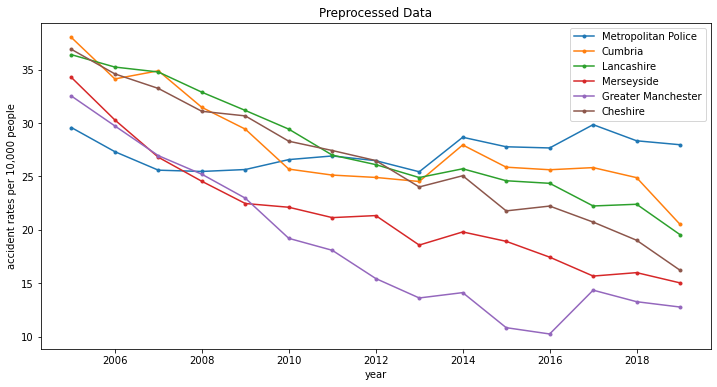

In [5]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(years,accident_data[i],marker='.', label=area_names[i])
plt.legend()
plt.title('Preprocessed Data')
plt.xlabel('year')
plt.ylabel('accident rates per 10,000 people')
plt.show()

In [6]:
print(df.T.describe().round(2).to_markdown())

|       |   Metropolitan Police |   Cumbria |   Lancashire |   Merseyside |   Greater Manchester |   Cheshire |
|:------|----------------------:|----------:|-------------:|-------------:|---------------------:|-----------:|
| count |                 15    |     15    |        15    |        15    |                15    |      15    |
| mean  |                 27.28 |     27.91 |        27.78 |        21.62 |                18.62 |      26.51 |
| std   |                  1.45 |      4.74 |         5.24 |         5.47 |                 7.15 |       6.01 |
| min   |                 25.43 |     20.5  |        19.54 |        15.03 |                10.25 |      16.21 |
| 25%   |                 26.06 |     25.01 |        24.47 |        18.01 |                13.44 |      21.99 |
| 50%   |                 27.31 |     25.82 |        26.1  |        21.14 |                15.44 |      26.48 |
| 75%   |                 28.14 |     30.44 |        32.03 |        23.5  |                24.08 |      

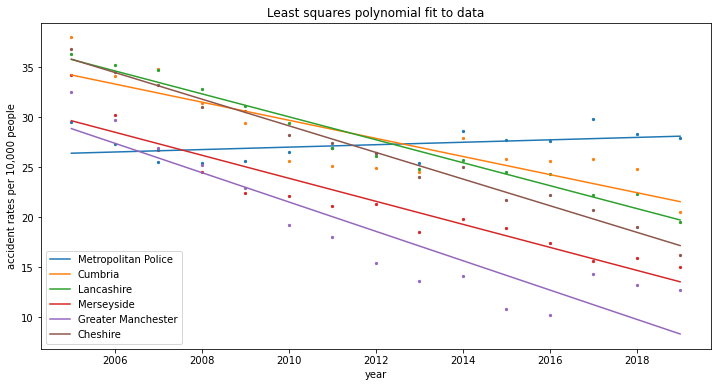

In [7]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.scatter(years, accident_data[i, :], marker='.', s=20)
    fit = np.polyfit(years, accident_data[i, :], 1)
    fitted_values = np.polyval(fit, years)
    plt.plot(years, fitted_values, label=area_names[i])
plt.legend()
plt.title('Least squares polynomial fit to data')
plt.xlabel('year')
plt.ylabel('accident rates per 10,000 people')
plt.show()

# 3. Probability Models

## 3.1 Separate Model

In a separate model, we treat each district as an individual entity, and assign independent parameters to them. Specifically, we assign individual parameters $\alpha_i$ and $\beta_i$ to the $i$th area, and make the mean vary linearly with respect to years. But each district will have a constant variance across all 15 years. The mathematical expression for the separate model can be specified with the following equations:
$$
\begin{aligned}
\alpha_i &\sim Normal(30, 20)\\
\beta_i &\sim Normal(0, 4.85)\\
\sigma_j &\sim uniform \\
\mu_{i,j} &= \alpha_i + \beta_i * year[j] \\
accident[i, j] &\sim Normal(\mu_{i,j}, \sigma_j)
\end{aligned}
$$


In [8]:
separate_model_name = 'accident_separate.stan'
separate_stan_model = pystan.StanModel(file=model_path + '/' + separate_model_name)
print(separate_stan_model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7118a747b64b48d22305b3d729749de8 NOW.


//
// This Stan program defines a simple model, with a
// vector of values 'y' modeled as normally distributed
// with mean 'mu' and standard deviation 'sigma'.
//
// Learn more about model development with Stan at:
//
//    http://mc-stan.org/users/interfaces/rstan.html
//    https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started
//

// The input data is a vector 'y' of length 'N'.
data {
  int<lower=0> N; // the number of police force
  int<lower=0> Y; // the number of years has been studied, year 2005 corresponds to 1
  matrix[N,Y] accidentData;//accident data
  int prior_choice; // choose different setup for prior distribution
  int xpred; // year of prediction (actual year)
}

// The parameters accepted by the model. Our model
// accepts two parameters 'mu' and 'sigma'.
parameters {
  vector[N] alpha;
  vector[N] beta;
  vector<lower=0>[N] sigma;
}

transformed parameters{
  matrix[N,Y]mu;
  for(i in 1:N)
    for(j in 1:Y)
      mu[i,j]=alpha[i]+beta[i]*j;
}

// The model to

In [9]:
def test_stan_model(stan_model, data, verbose = False):   
    data_for_stan = dict(
        N = data.shape[0],
        Y = data.shape[1],
        accidentData = data,
        years = np.arange(1, data.shape[1]+1), # stan index starts from 1
        xpred=2020,
        prior_choice=1
    )
    stan_results = stan_model.sampling(data=data_for_stan)
    if verbose:
        print(stan_results)
    return stan_results

In [10]:
separate_results = test_stan_model(separate_stan_model, accident_data, verbose=True)

Inference for Stan model: anon_model_7118a747b64b48d22305b3d729749de8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]       26.32    0.02   0.87  24.64  25.76  26.32  26.88  28.02   2349    1.0
alpha[2]       35.13    0.03    1.6  31.99  34.14  35.14  36.15  38.26   2732    1.0
alpha[3]       36.93    0.01    0.7  35.47  36.49  36.95  37.38  38.29   2589    1.0
alpha[4]        30.8    0.03    1.2  28.34  30.04  30.79  31.56  33.16   2274    1.0
alpha[5]       30.35    0.04   1.79  26.81   29.2  30.38   31.5  33.93   2371    1.0
alpha[6]       37.15  9.5e-3    0.5  36.17  36.82  37.14  37.47  38.15   2815    1.0
beta[1]         0.12  2.0e-3    0.1  -0.07   0.06   0.12   0.18   0.31   2307    1.0
beta[2]         -0.9  3.4e-3   0.18  -1.25  -1.01   -0.9  -0.79  -0.56   2605    1.0
beta[3]        -1.14  1.5e-3   0.08   -1.3  -1

## 3.2 Pooled Model
$$
\begin{aligned}
\alpha &\sim Normal(30, 20)\\
\beta &\sim Normal(0, 4.85)\\
\sigma_j &\sim uniform \\
\mu_{j} &= \alpha + \beta * year[j] \\
accident[:, j] &\sim Normal(\mu_{j}, \sigma_j)
\end{aligned}
$$

In [11]:
pooled_model_name = 'accident_pooled.stan'
pooled_stan_model = pystan.StanModel(file=model_path + '/' + pooled_model_name)
print(pooled_stan_model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_78401062c54be5038724f93ddb7d812c NOW.


//
// This Stan program defines a simple model, with a
// vector of values 'y' modeled as normally distributed
// with mean 'mu' and standard deviation 'sigma'.
//
// Learn more about model development with Stan at:
//
//    http://mc-stan.org/users/interfaces/rstan.html
//    https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started
//

data {
  int<lower=0> N; // the number of police force
  int<lower=0> Y; // the number of years has been studied, year 2005 corresponds to 1
  matrix[N,Y] accidentData;//accident data
  int prior_choice; // choose different setup for prior distribution
  int xpred; // year of prediction (actual year)
}



parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters{
  vector[Y]mu;
  //linear model
  for(j in 1:Y)
    mu[j]=alpha+beta*j;
}


model {
  //prior
  if (prior_choice==3){
    // weaker prior 
    alpha~normal(0,100);
    beta~normal(0,10);
  } else if (prior_choice==2) {
    // uniform prior
  } else {
    // de

In [12]:
pooled_results = test_stan_model(pooled_stan_model, accident_data, verbose=True)

Inference for Stan model: anon_model_78401062c54be5038724f93ddb7d812c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha          32.78    0.03   1.05   30.6  32.08   32.8   33.5  34.83   1635    1.0
beta           -0.98  2.9e-3   0.12  -1.21  -1.06  -0.98   -0.9  -0.75   1570    1.0
sigma           4.72  7.4e-3   0.36   4.07   4.46    4.7   4.95   5.48   2362    1.0
mu[1]           31.8    0.02   0.95  29.82  31.18  31.82  32.45  33.65   1677    1.0
mu[2]          30.82    0.02   0.86  29.05  30.26  30.83   31.4  32.48   1741    1.0
mu[3]          29.84    0.02   0.77  28.24  29.35  29.84  30.35   31.3   1841    1.0
mu[4]          28.86    0.02   0.68  27.43  28.42  28.86  29.31  30.18   1997    1.0
mu[5]          27.88    0.01   0.61  26.62  27.49  27.88  28.28  29.08   2242    1.0
mu[6]           26.9    0.01   0.55  25.77  26

## 3.3 Hierarchical Model

In [13]:
hier_model_name = 'accident_hierarchical.stan'
hier_stan_model = pystan.StanModel(file=model_path + '/' + hier_model_name)
print(hier_stan_model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_40aecd51cc828896ccffcb762a178e52 NOW.


//
// This Stan program defines a simple model, with a
// vector of values 'y' modeled as normally distributed
// with mean 'mu' and standard deviation 'sigma'.
//
// Learn more about model development with Stan at:
//
//    http://mc-stan.org/users/interfaces/rstan.html
//    https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started
//

data {
  int<lower=0> N; // the number of police force
  int<lower=0> Y; // the number of years has been studied, year 2005 corresponds to 1
  matrix[N,Y] accidentData;//accident data
  int prior_choice; // choose different setup for prior distribution
  int xpred; // year of prediction (actual year)
}


parameters {
  real mu_alpha;
  real mu_beta;
  real<lower=0> sigma_alpha;
  real<lower=0> sigma_beta;
  vector[N] alpha;
  vector[N] beta;
  // vector<lower=0>[N] sigma;
  real<lower=0> sigma;
}


transformed parameters{
  matrix[N,Y]mu;
  for(i in 1:N)
    for(j in 1:Y)
      mu[i,j]=alpha[i]+beta[i]*j;
}


model {
  if (prior_choice==3){
    // b

In [14]:
hier_results = test_stan_model(hier_stan_model, accident_data, verbose=True)

Inference for Stan model: anon_model_40aecd51cc828896ccffcb762a178e52.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_alpha       32.72    0.05   2.51  27.71  31.33  32.69  34.04  37.83   2692    1.0
mu_beta        -0.96  8.5e-3   0.38  -1.63  -1.16  -0.98  -0.79  -0.22   1952    1.0
sigma_alpha     5.61    0.06   2.77   2.57   3.88   4.93   6.49  13.23   2172    1.0
sigma_beta      0.77  9.9e-3   0.41   0.35   0.52   0.67    0.9   1.78   1709    1.0
alpha[1]       26.95    0.02   1.11  24.77   26.2  26.95  27.65   29.2   2990    1.0
alpha[2]       35.02    0.02   1.03  32.99  34.34  35.03   35.7  37.04   2779    1.0
alpha[3]       36.67    0.02   1.07  34.59  35.95  36.66  37.39  38.81   3381    1.0
alpha[4]       30.89    0.02   1.04  28.86  30.22   30.9  31.57  32.93   3469    1.0
alpha[5]       30.35    0.02   1.06  28.28  29

# 4. Model Evaluation

In [15]:
var_separate =["alpha", "beta", "sigma"] # the variables that need to be plotted
var_pooled = ["alpha", "beta", "sigma"] 
var_hier = ["alpha", "beta", "mu_alpha", "sigma_alpha", "mu_beta", "sigma_beta"]

## 4.1 Cross-Validation with PSIS-LOO

In [16]:
def get_psis_loo_result(stan_results):
    idata = az.from_pystan(stan_results, log_likelihood="log_lik")
    loo_results = az.loo(idata, pointwise=True)
    print(loo_results)
    khats = loo_results.pareto_k
    az.plot_khat(khats, xlabels=True, annotate=True, figsize=(12, 6))
    plt.show()

/home/weijiang/anaconda3/envs/bda/lib/python3.7/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo  -186.56     8.00
p_loo       16.52        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       86   95.6%
 (0.5, 0.7]   (ok)          2    2.2%
   (0.7, 1]   (bad)         1    1.1%
   (1, Inf)   (very bad)    1    1.1%



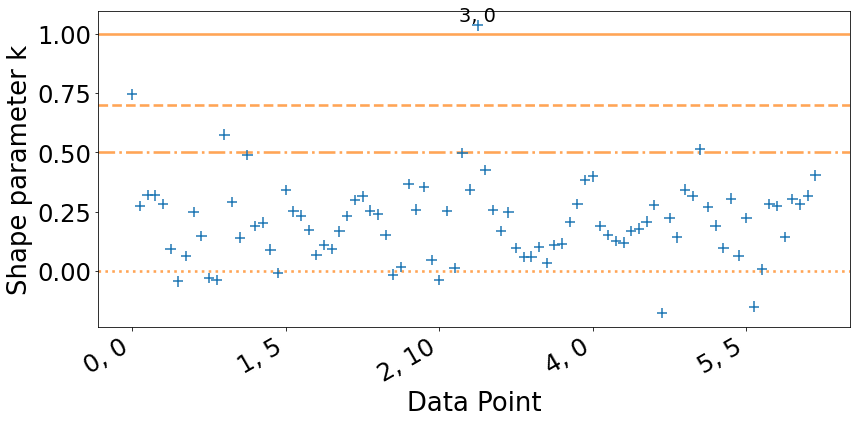

In [17]:
get_psis_loo_result(separate_results)

Computed from 4000 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo  -267.80     6.29
p_loo        2.82        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       90  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



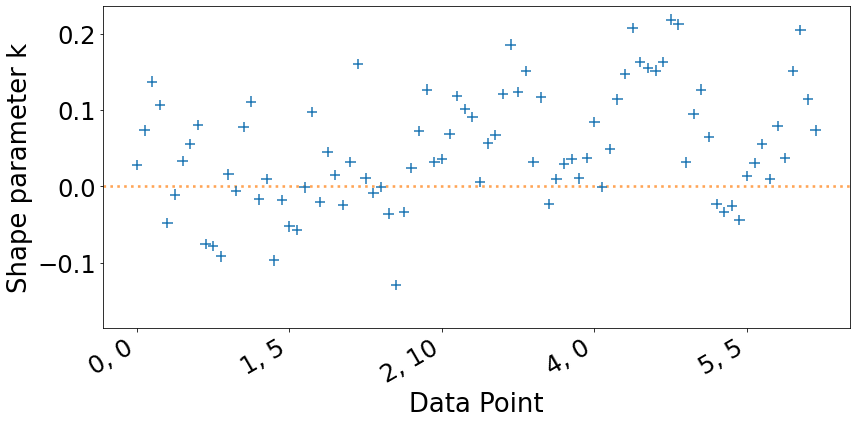

In [18]:
get_psis_loo_result(pooled_results)

Computed from 4000 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo  -196.42     6.86
p_loo       12.93        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       88   97.8%
 (0.5, 0.7]   (ok)          2    2.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



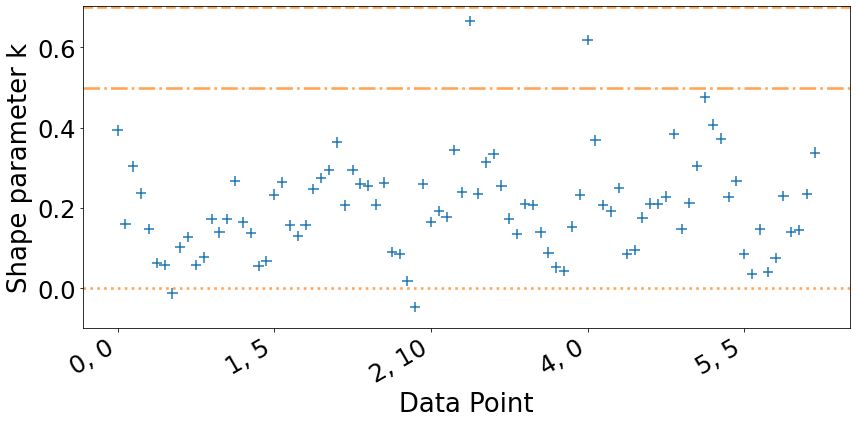

In [19]:
get_psis_loo_result(hier_results)

## 4.2 Effective Sample Sizes

need to know how to interprete these plots
https://mc-stan.org/docs/2_25/reference-manual/effective-sample-size-section.html

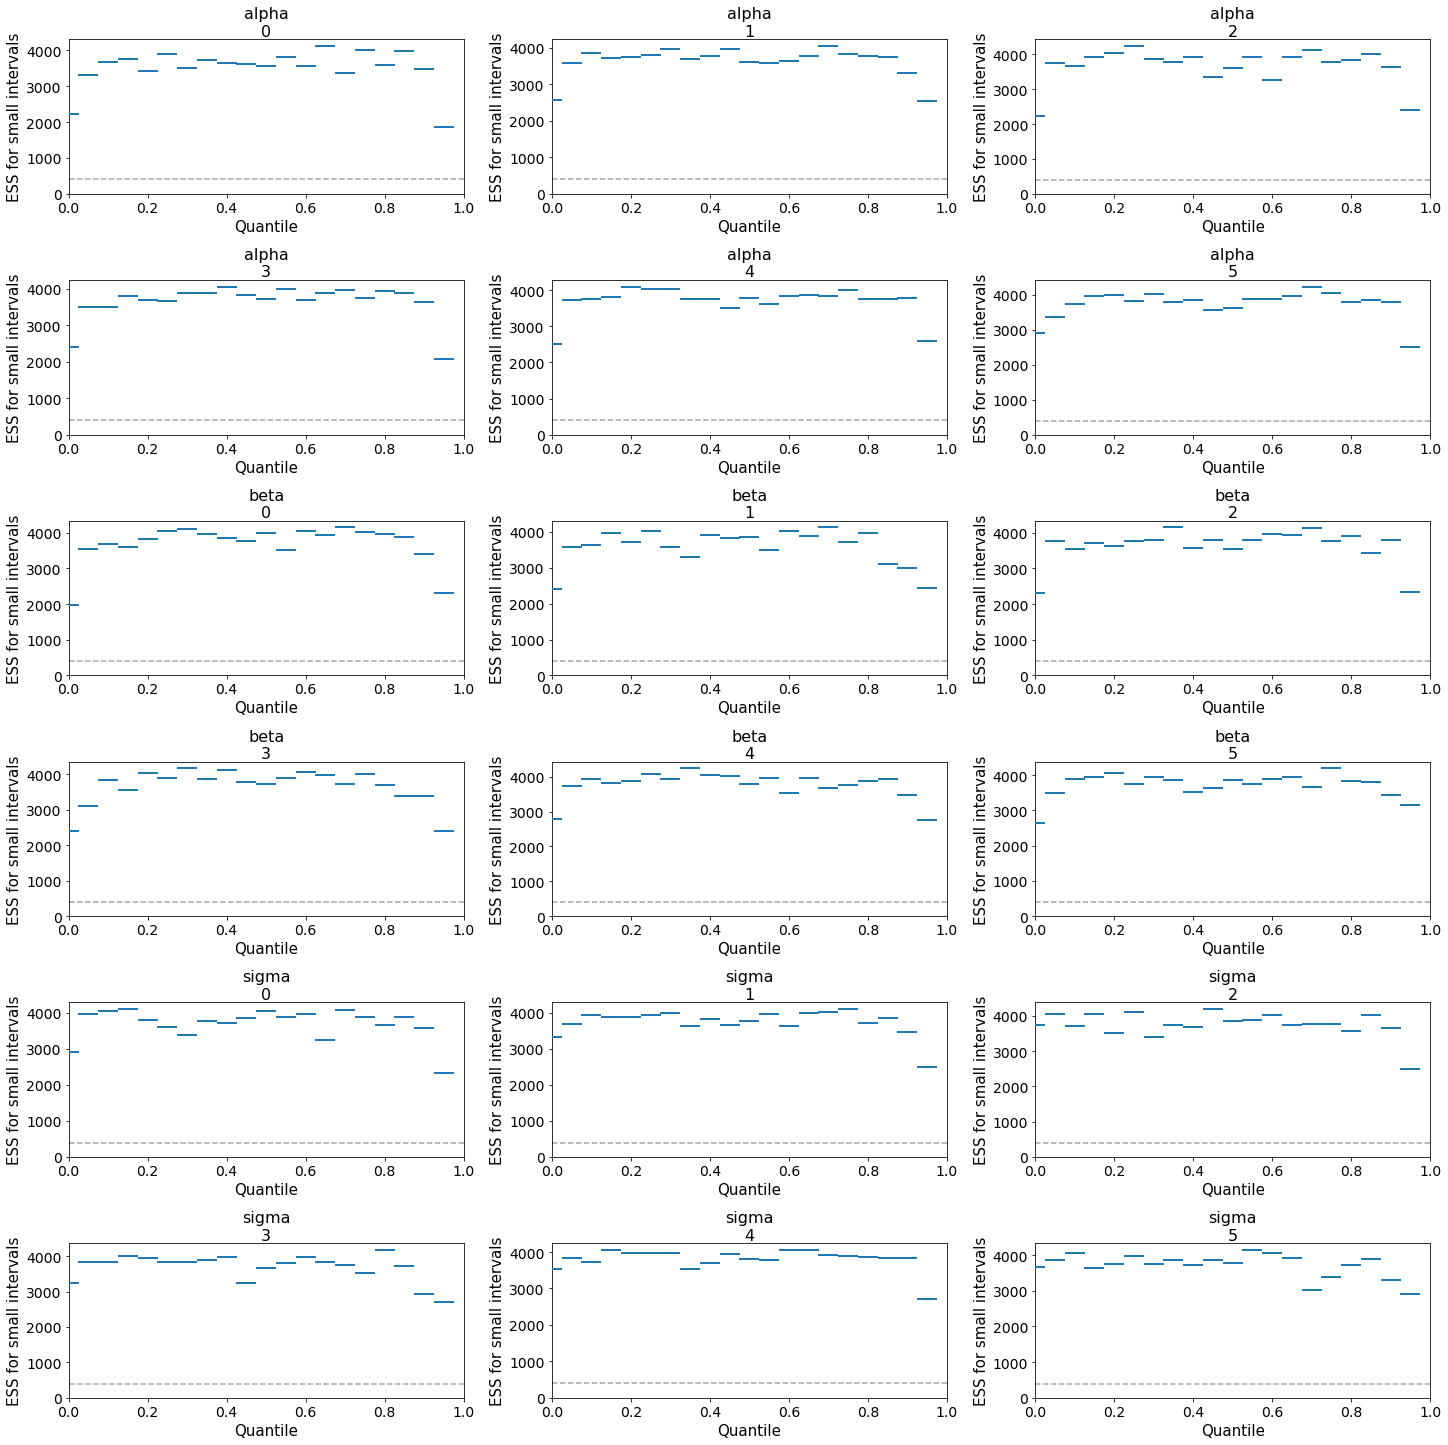

In [20]:
_ = az.plot_ess(
    separate_results, var_names=var_separate, 
    kind="local", marker="_", ms=20, mew=2, figsize=(20, 20)
)

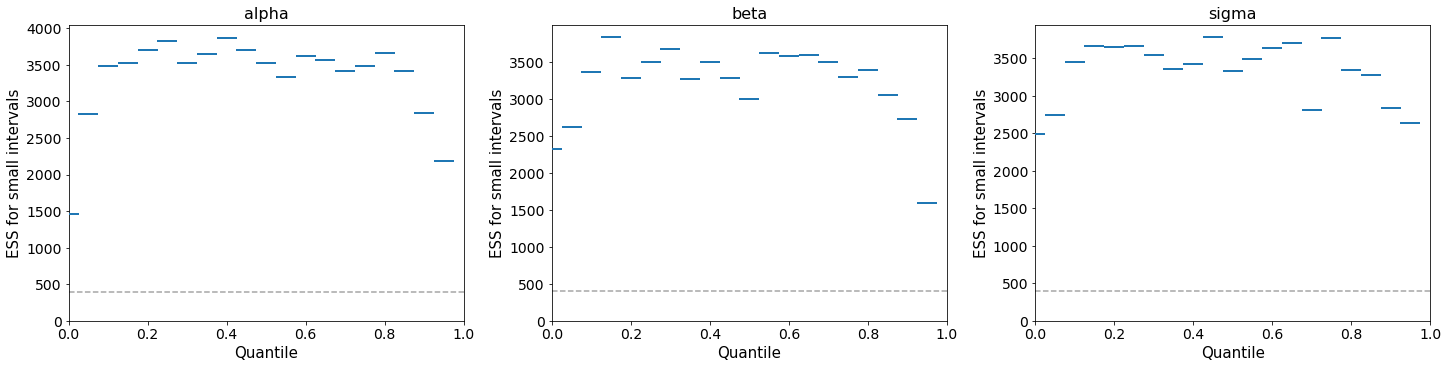

In [21]:
_ = az.plot_ess(
    pooled_results, var_names=var_pooled, 
    kind="local", marker="_", ms=20, mew=2, figsize=(20, 5)
)

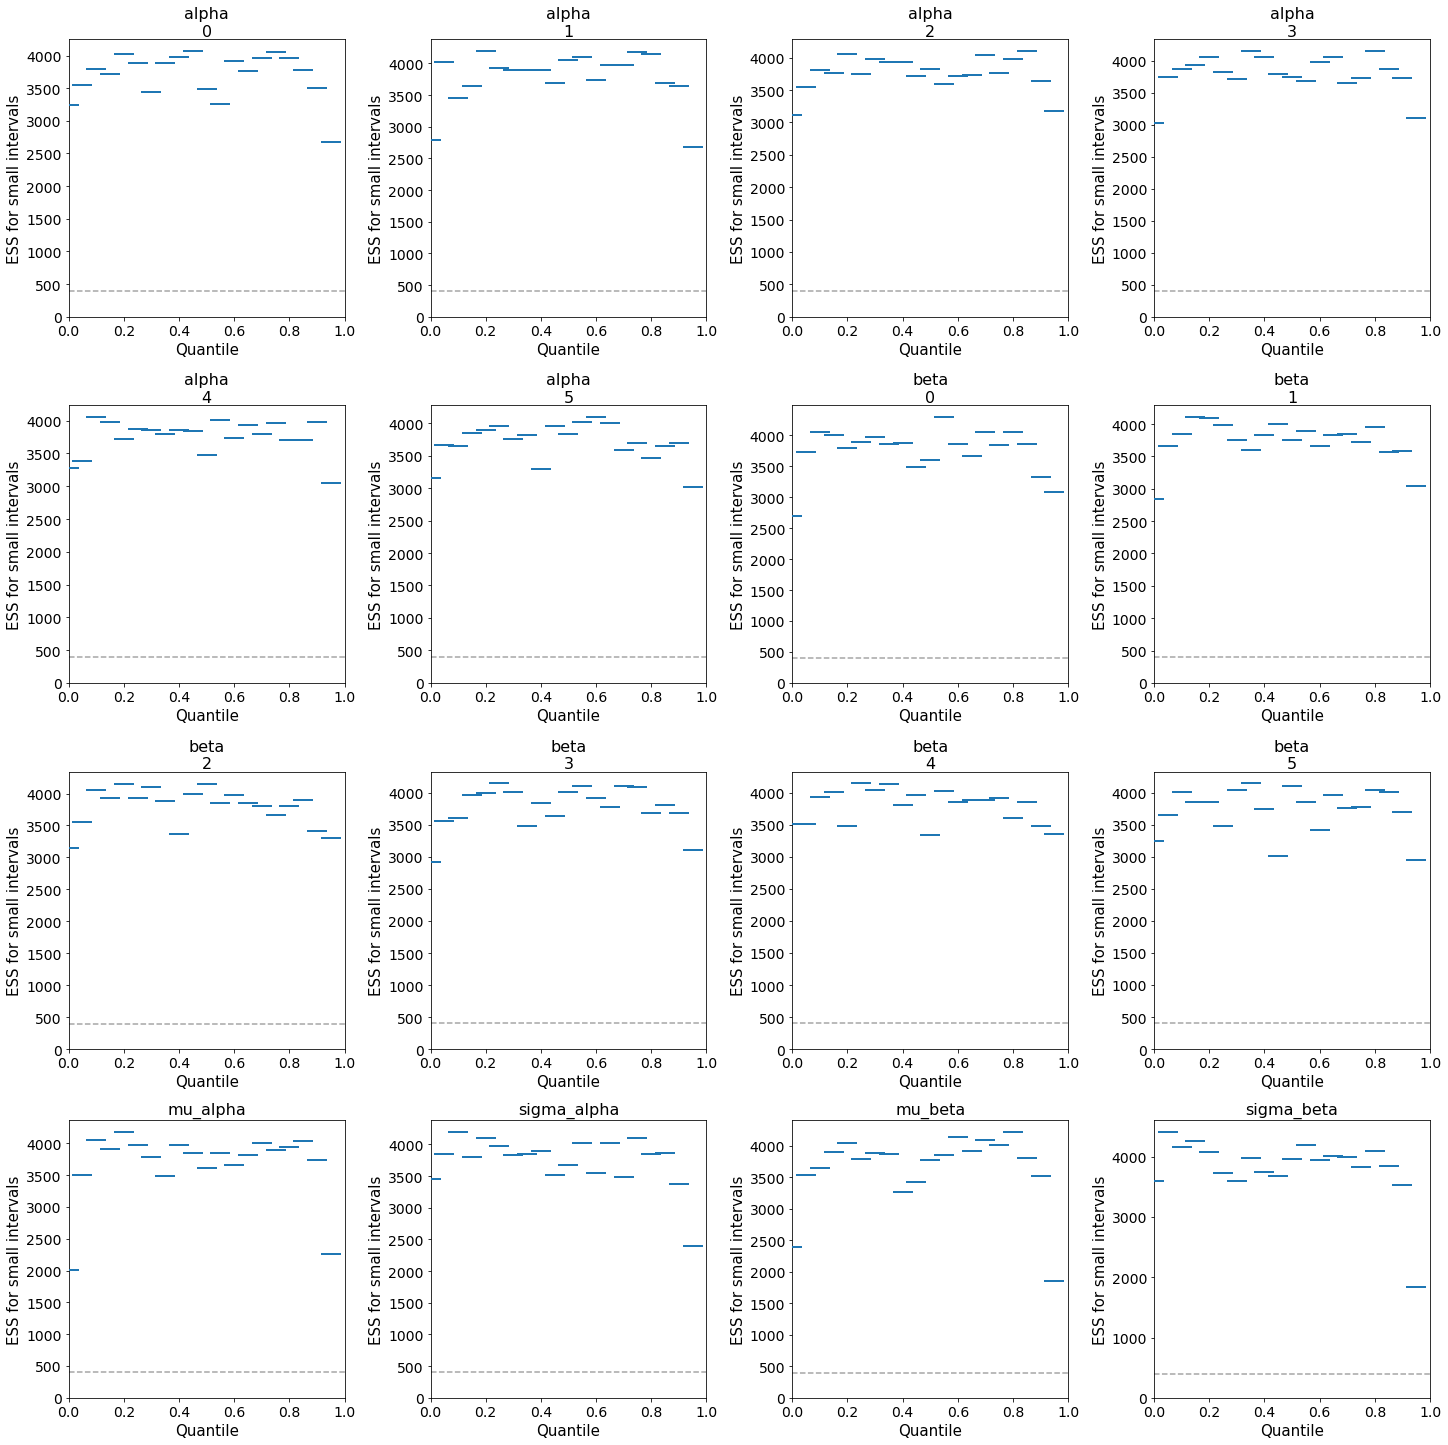

In [22]:
_ = az.plot_ess(
    hier_results, var_names=var_hier, 
    kind="local", marker="_", ms=20, mew=2, figsize=(20, 20)
)

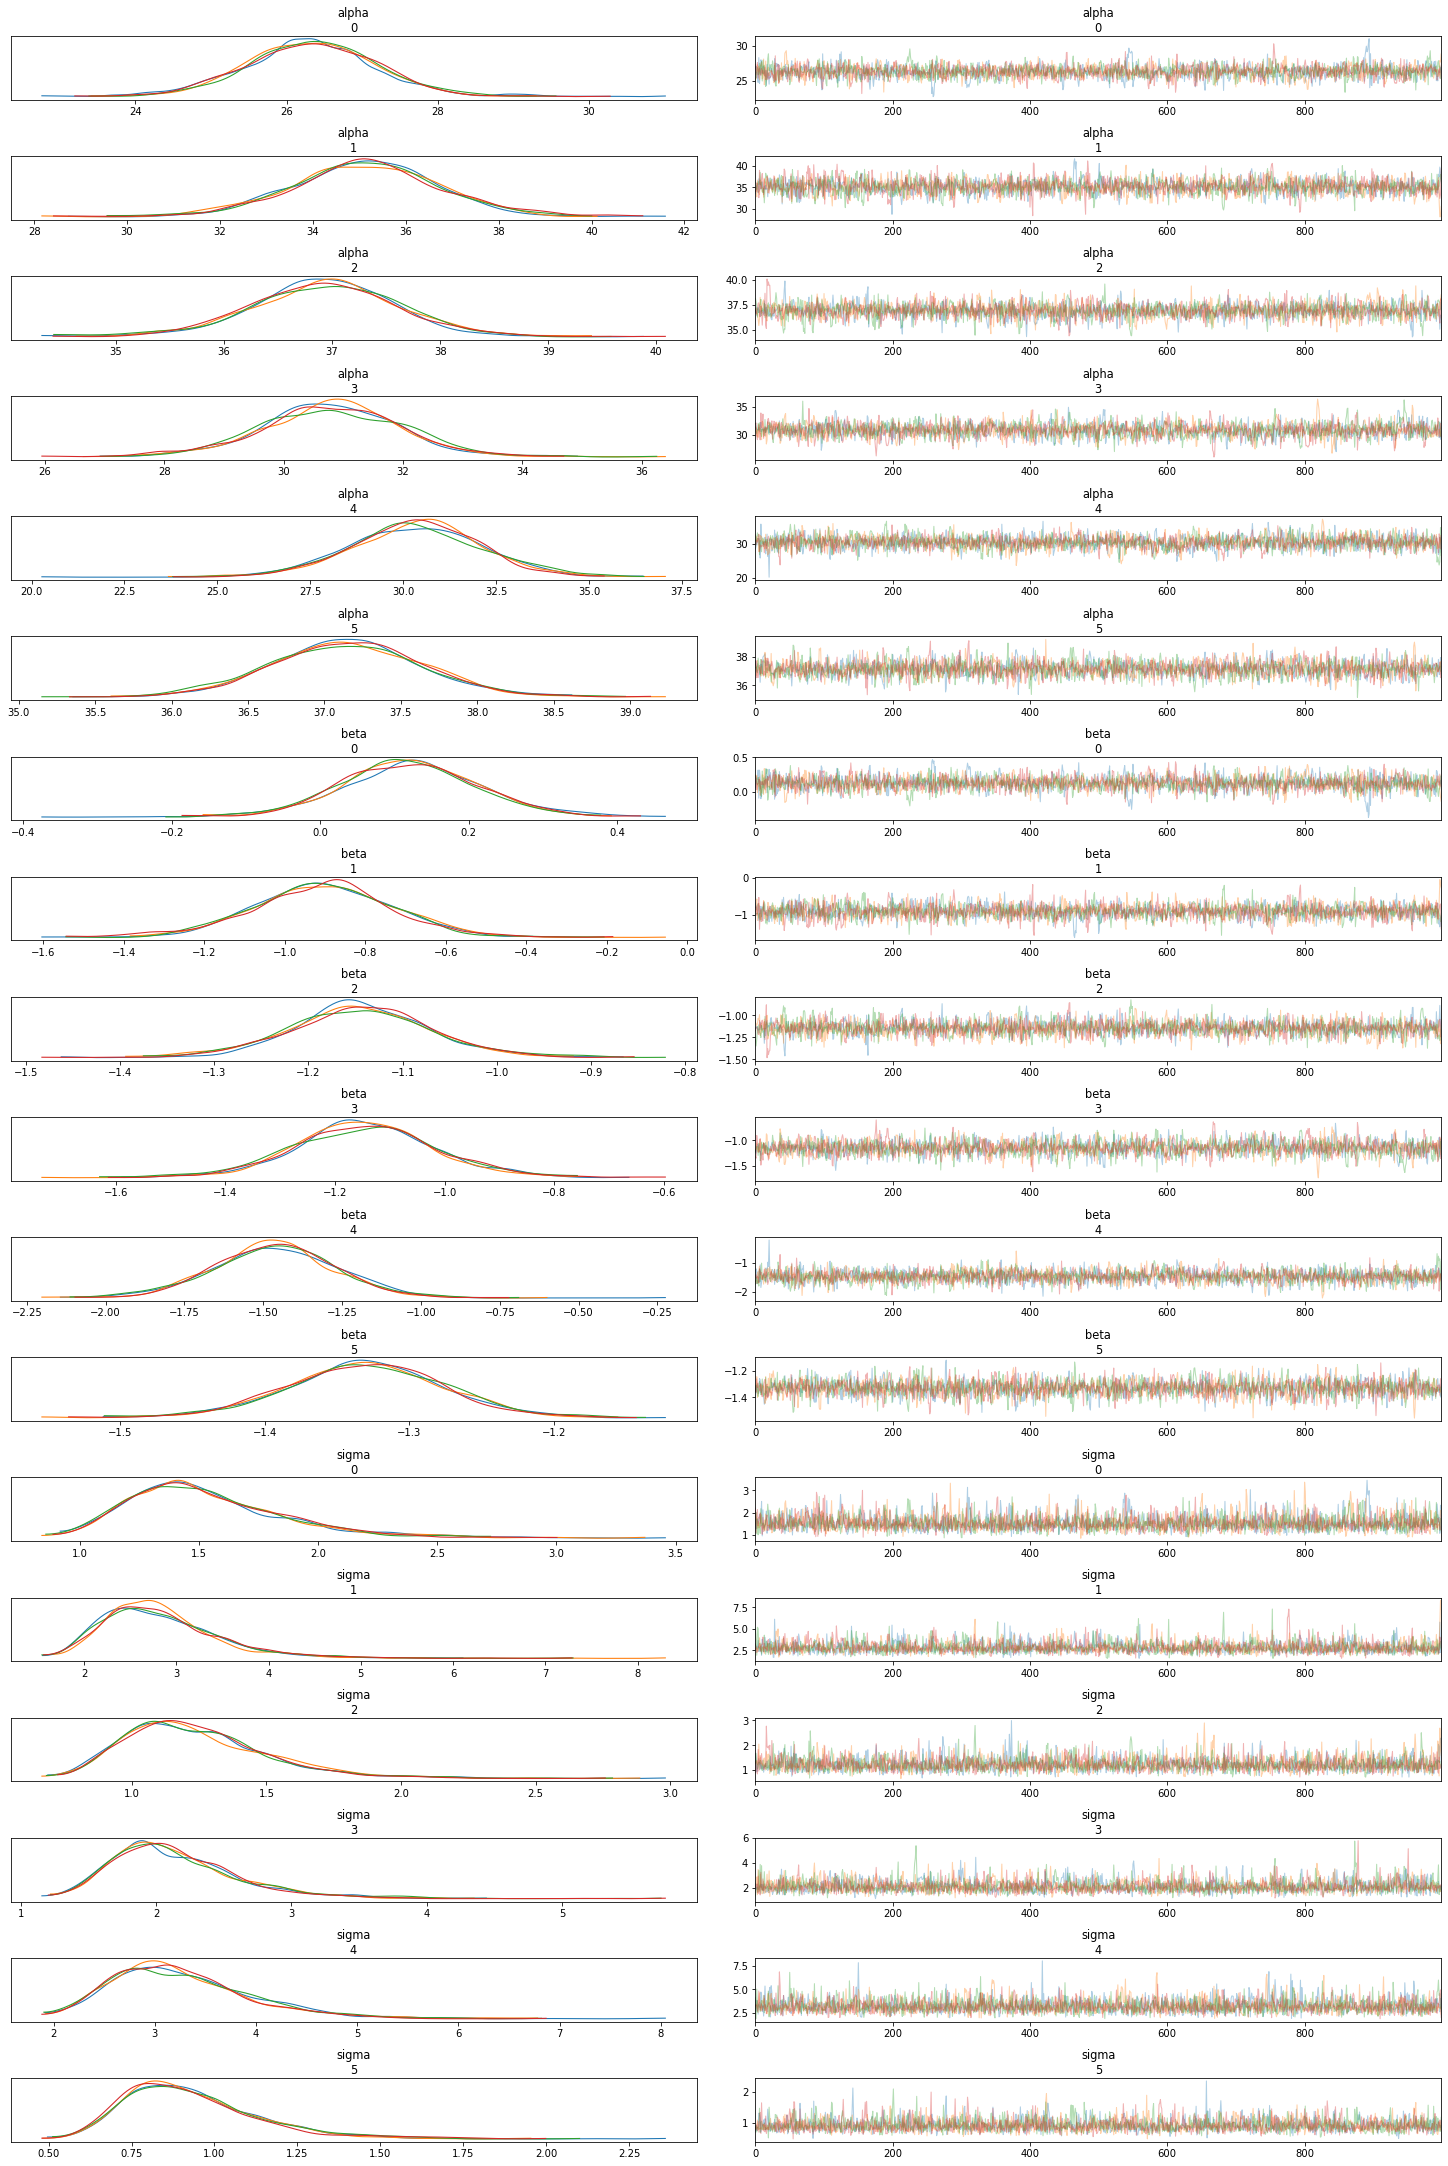

In [23]:
_ = az.plot_trace(separate_results, var_names = var_separate, figsize=(20, 30))

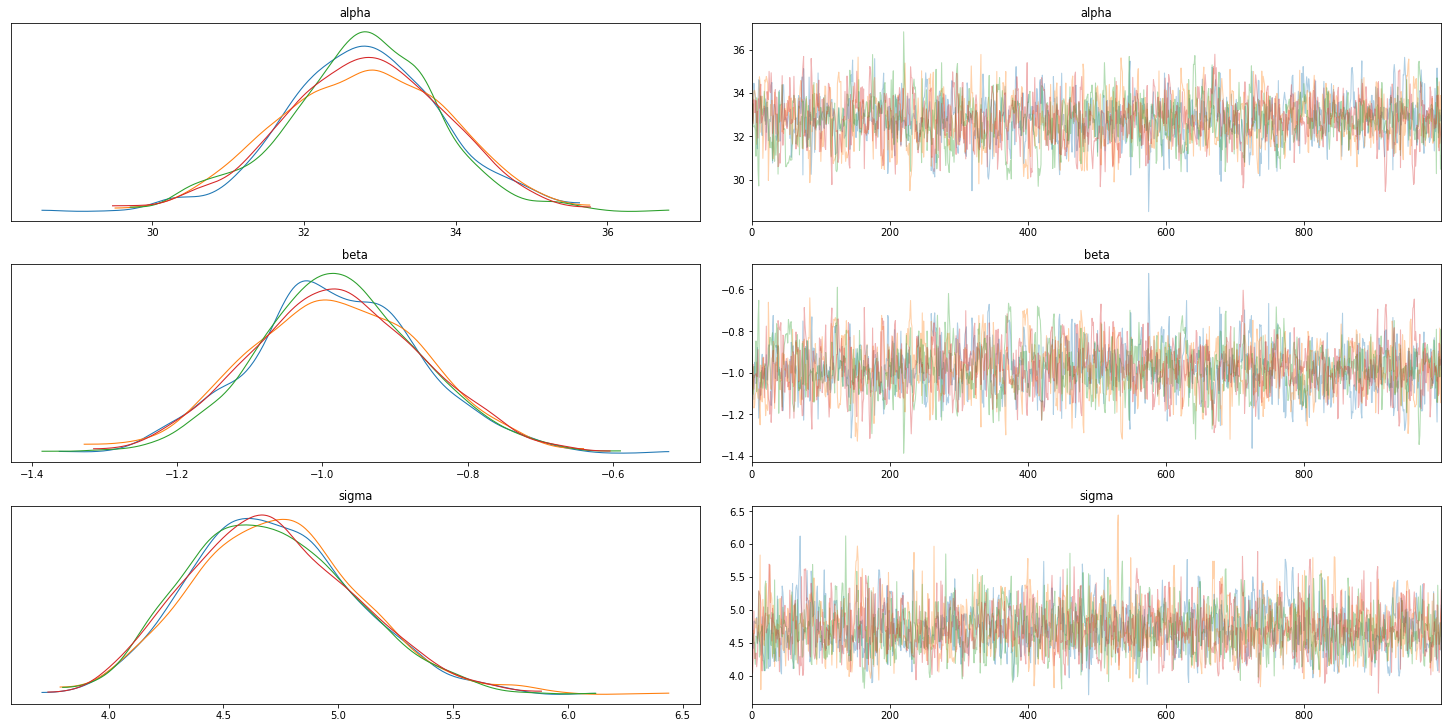

In [24]:
_ = az.plot_trace(pooled_results, var_names = var_pooled, figsize=(20, 10))

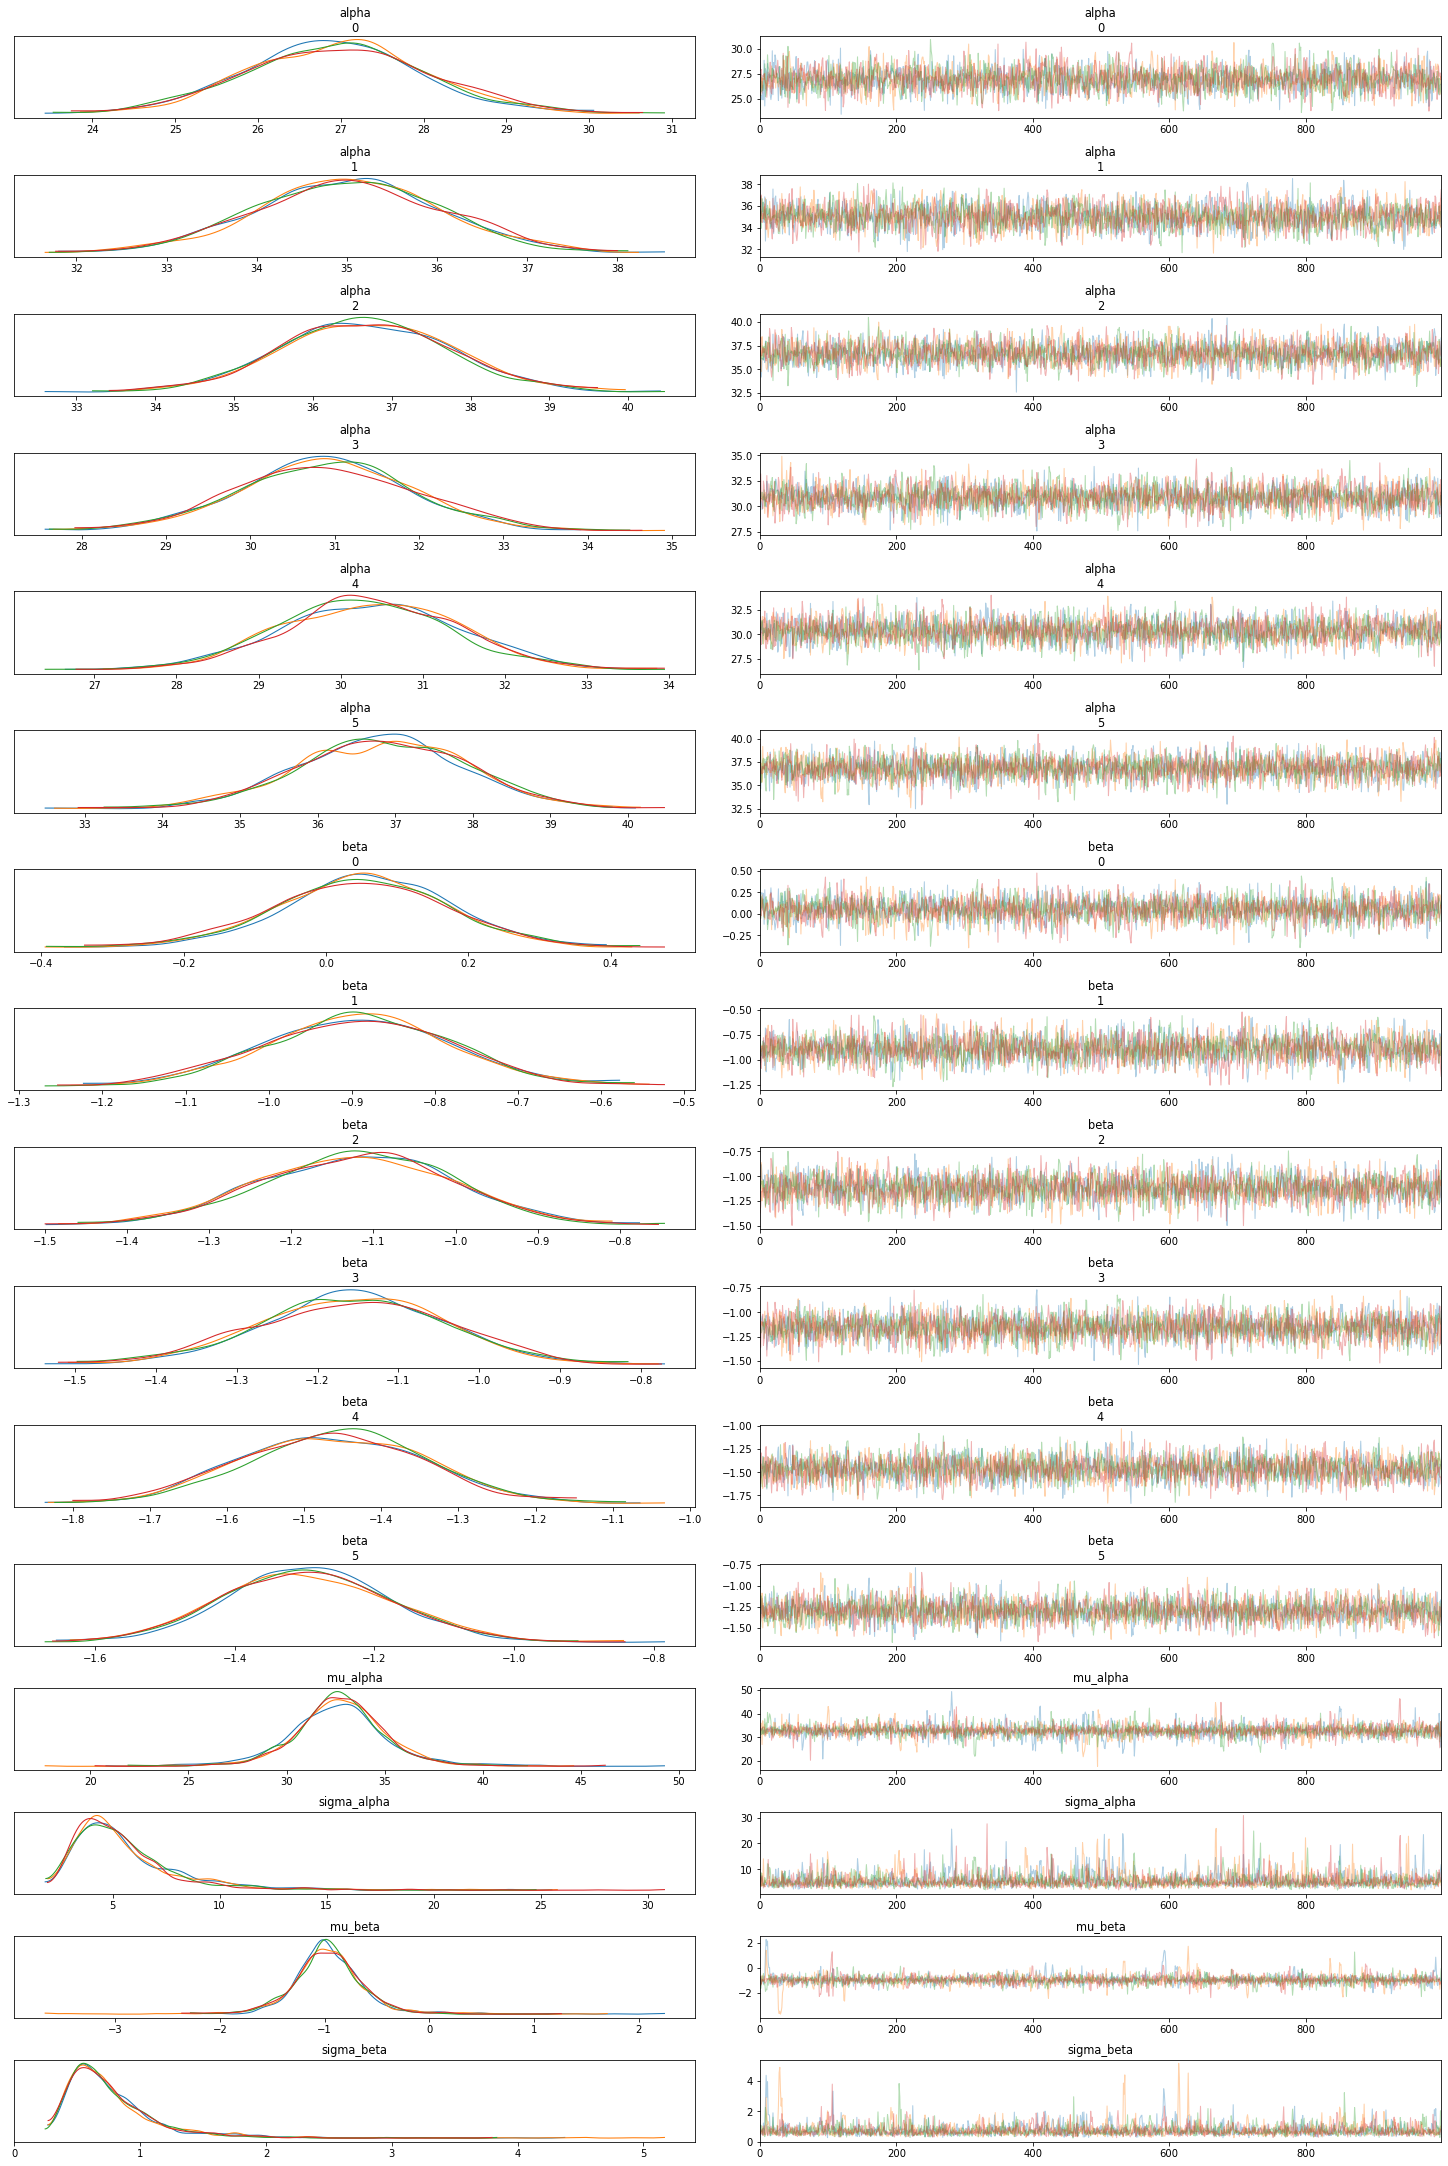

In [25]:
_ = az.plot_trace(hier_results, var_names = var_hier, figsize=(20, 30))

In [26]:
def get_treedepth(stan_results):    
    h = stan_results.to_dataframe(diagnostics=True)
    print('max treedepth for draws: ', h['treedepth__'].max())
    print('min treedepth for draws: ', h['treedepth__'].min())
    print('mean treedepth for draws: ', h['treedepth__'].mean())
    print('divergent transitions: ', any(h['divergent__']))

need discussion, divergent transitions false means good

In [27]:
get_treedepth(separate_results)
get_treedepth(pooled_results)
get_treedepth(hier_results)

max treedepth for draws:  6
min treedepth for draws:  3
mean treedepth for draws:  4.255
divergent transitions:  False
max treedepth for draws:  4
min treedepth for draws:  1
mean treedepth for draws:  2.886
divergent transitions:  False
max treedepth for draws:  6
min treedepth for draws:  2
mean treedepth for draws:  3.96825
divergent transitions:  False


## 4.3 Posterior Predictive Checking

In [28]:
def plot_posterior_draws(stan_results, accident_data, pooled=False):    
    plt.figure(figsize=(15,10))
    year_idx = np.arange(accident_data.shape[1])+1
    actual_years = year_idx + 2004

    colors = ['red', 'cyan', 'orange', 'gray', 'green', 'purple']
    for x in range(1, 7):
        for i in range(100):
            if pooled:
                y = stan_results["beta"][i] * year_idx + stan_results["alpha"][i]
            else:
                y = stan_results["beta"][:, x-1][i] * year_idx + stan_results["alpha"][:, x-1][i]
            _ = plt.plot(actual_years, y, color=colors[x-1], alpha=0.05)
        if pooled:
            break
        

    for x in range(1, 7):
        for j in reversed(range(1, 16)):
            yrep = stan_results['yrep[{},{}]'.format(x, j)]
            _ = plt.errorbar(
                x = actual_years[j-1], 
                y = np.mean(yrep),
                yerr=np.std(yrep), 
                fmt='--o', zorder=i+j,
                ecolor='black', capthick=2,
                color='black',
                alpha=0.5
            )

    for k in range(1, 7):
        ypred = stan_results['pred[{}]'.format(k)]
        _ = plt.errorbar(
            x = 2020, 
            y = np.mean(ypred), 
            yerr=np.std(ypred), 
            fmt='--o', zorder=i+j+100,
            ecolor='red', capthick=2,
            color='red',
        )


    _ = plt.scatter(np.tile(years, 6), accident_data.flatten(), zorder=j+i+100, edgecolors='black')
    # _ = plt.scatter(data_for_stan["years"], data_for_stan["accidentData"], zorder=j+i+100, edgecolors='black')
    _ = plt.title("Posterior predictive check")
    _ = plt.legend(bbox_to_anchor=(1.05, 1), loc='lower left', borderaxespad=0.)


    # area_names = ["Metropolitan Police", 'Cumbria','Lancashire',
    #                'Merseyside','Greater Manchester','Cheshire']

    custom_lines = [
        Line2D([0], [0], color='red', lw=4, label='Metropolitan Police'),
        Line2D([0], [0], color='cyan', lw=4, label='Cumbria'),
        Line2D([0], [0], color='orange', lw=4, label='Lancashire'),
        Line2D([0], [0], color='gray', lw=4, label='Merseyside'),
        Line2D([0], [0], color='green', lw=4, label='Greater Manchester'),
        Line2D([0], [0], color='purple', lw=4, label='Cheshire'),
        Line2D([0], [0], marker='o', color='black', label='Original datapoint', markerfacecolor='b', markersize=15),
        Line2D([0], [0], marker='o', color='red', label='Predictions 2020', markersize=15),
        Line2D([0], [0], marker='o', color='black', label='Posterior samples', markersize=15),
    ]

    _ = plt.legend(handles=custom_lines, bbox_to_anchor=(1, 1))
    _ = plt.xticks(np.arange(2005, 2021), fontsize=13)
    _ = plt.yticks(fontsize=14)

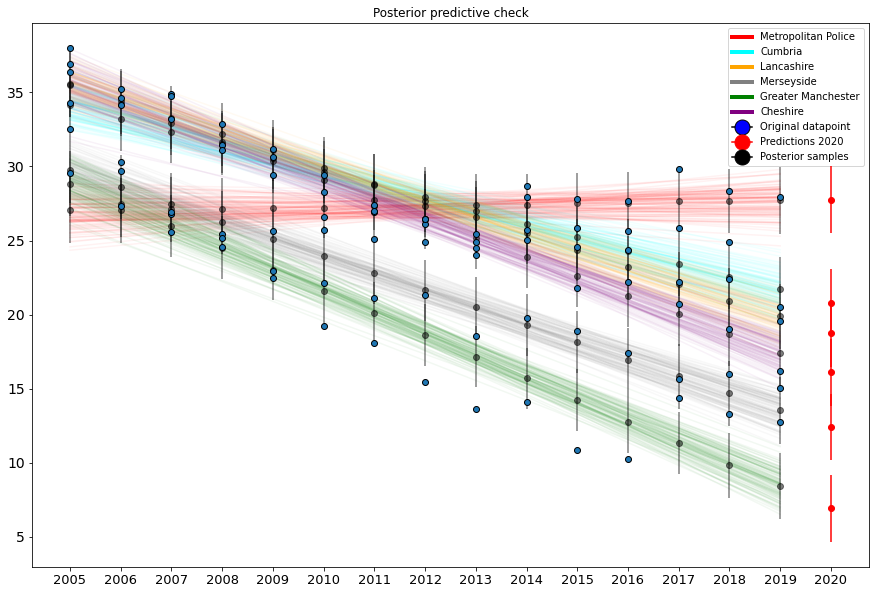

In [29]:
plot_posterior_draws(hier_results, accident_data)

In [30]:
az.r2_score(accident_data, hier_results["yrep"])

r2        0.885864
r2_std    0.005769
dtype: float64

In [36]:
np.mean(hier_results["pred"][:,0])*8961989/10000

24872.73396001533

In [ ]:
accident_data

In [ ]:
plot_posterior_draws(separate_results, accident_data)

In [ ]:
az.r2_score(accident_data, separate_results["yrep"])

In [ ]:
plot_posterior_draws(pooled_results, accident_data, pooled=True)

In [ ]:
az.r2_score(accident_data, pooled_results["yrep"])

## 4.4 Prior Sensitivity Test

In [ ]:
data_dict = dict()
names = ["default_prior", "uniform_prior", "bigger_variance"]
for i in range(3):
    current_stan_data = dict(
        N = accident_data.shape[0],
        Y = accident_data.shape[1],
        accidentData = accident_data,
        years = np.arange(1, accident_data.shape[1]+1), # stan index starts from 1
        xpred=2020,
        prior_choice= i+1
    )
    data_dict[names[i]] = current_stan_data

In [ ]:
def get_plot_forest(stan_model, data_dict, pooled=False):
    if pooled:
        figsize = (20, 5)
    else:
        figsize = (20, 20)
    result_dict = dict()
    for key, stan_data in data_dict.items():
        print("Generating results with prior:{} {}".format(stan_data["prior_choice"], key))
        sampling_result = stan_model.sampling(data=stan_data)
        #print(sampling_result)
        result_dict[key] = sampling_result
    _ = az.plot_forest(
    list(result_dict.values()), 
    model_names=list(result_dict.keys()), var_names=["beta"], markersize=10,
    kind='ridgeplot', ridgeplot_overlap=3, ridgeplot_alpha=0.3, r_hat=True, \
        ess=True, figsize=figsize, textsize=20)
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.show()

In [ ]:
get_plot_forest(hier_stan_model, data_dict)

In [ ]:
get_plot_forest(separate_stan_model, data_dict)

In [ ]:
get_plot_forest(pooled_stan_model, data_dict)